# Enfoque 1 (Aleatorio) - Fase 2 Optimización (GRID RF criterio RMSE penalizado) + Inputs Trat 2 DROP


In [ ]:
import pandas as pd
import numpy as np


# Gráficos
import matplotlib.pyplot as plt

# Preprocesado y modelado
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_validate
from sklearn.ensemble import RandomForestRegressor


from tqdm.auto import tqdm
# Para Importar funciones generadas ad-hoc
import importlib
import TFM_errores as tfm_err
importlib.reload(tfm_err)

C:\Users\Elena\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe


<module 'TFM_errores' from 'c:\\Users\\Elena\\OneDrive\\Desktop\\Proyecto PY KSChool_1\\TFM\\TFM_errores.py'>

## Carga DATOS INPUTS - Tratados 2 (con variables adiconales)

In [ ]:
df_total = pd.read_csv('SET_INPUTS_TRAT_2.csv', sep=',', encoding='latin-1')

# 1) Asegura orden temporal (ajusta nombres de columnas)
df_total = df_total.sort_values(["time_idx"]).reset_index(drop=True)

# 2) Define features y target
X = df_total.drop(columns=['Price_Elec_EUR_MWh','Year','Month','Day','DayOfYear'], axis=1)
y = df_total['Price_Elec_EUR_MWh']

## División datos (Suffle)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

# Optimización con RMSE penalizando overfitting

In [ ]:
# -----------------------
# Grid
# -----------------------
v_hojas = [20,50, 75, 100, 125]
v_arboles = [50, 200, 500, 1000, 1500]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepara X una sola vez (evita repetir drop en cada iteración)
X_train_drop = X_train.drop(columns=["time_idx"])

# Aquí guardamos TODOS los resultados
rows = []

# (Opcional) seguimos dibujando curvas por hojas
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for hh in v_hojas:
    rmse_train_mean = np.zeros(len(v_arboles))
    rmse_val_mean   = np.zeros(len(v_arboles))

    for i, B in enumerate(v_arboles):
        rf = RandomForestRegressor(
            max_leaf_nodes=hh,
            n_estimators=B,
            random_state=42,
            n_jobs=1
        )

        cv_out = cross_validate(
            rf,
            X_train_drop,
            y_train,
            cv=cv,
            scoring="neg_root_mean_squared_error",
            return_train_score=True,
            n_jobs=1
        )

        # scores por fold (negativos) -> RMSE positivo
        train_rmse_folds = -cv_out["train_score"]
        val_rmse_folds   = -cv_out["test_score"]

        # medias (para plot y para tabla)
        rmse_train_mean[i] = train_rmse_folds.mean()
        rmse_val_mean[i]   = val_rmse_folds.mean()

        # guardamos una fila con TODO lo relevante
        rows.append({
            "max_leaf_nodes": hh,
            "n_estimators": B,

            "rmse_train_mean": train_rmse_folds.mean(),
            "rmse_train_std":  train_rmse_folds.std(ddof=1),

            "rmse_val_mean":   val_rmse_folds.mean(),
            "rmse_val_std":    val_rmse_folds.std(ddof=1),

            # por si quieres penalizar overfitting luego
            "gap_mean":        (val_rmse_folds - train_rmse_folds).mean(),
            "gap_pos_mean":    np.maximum(0.0, val_rmse_folds - train_rmse_folds).mean(),
        })


df_grid = pd.DataFrame(rows).sort_values(["max_leaf_nodes", "n_estimators"]).reset_index(drop=True)

# Guardar resultados (opcional)
df_grid.to_excel("E1_ALEA_Opt2_RMSE_RF_grid_cv.xlsx", index=False)

print("Grid guardada en df_grid")
df_grid

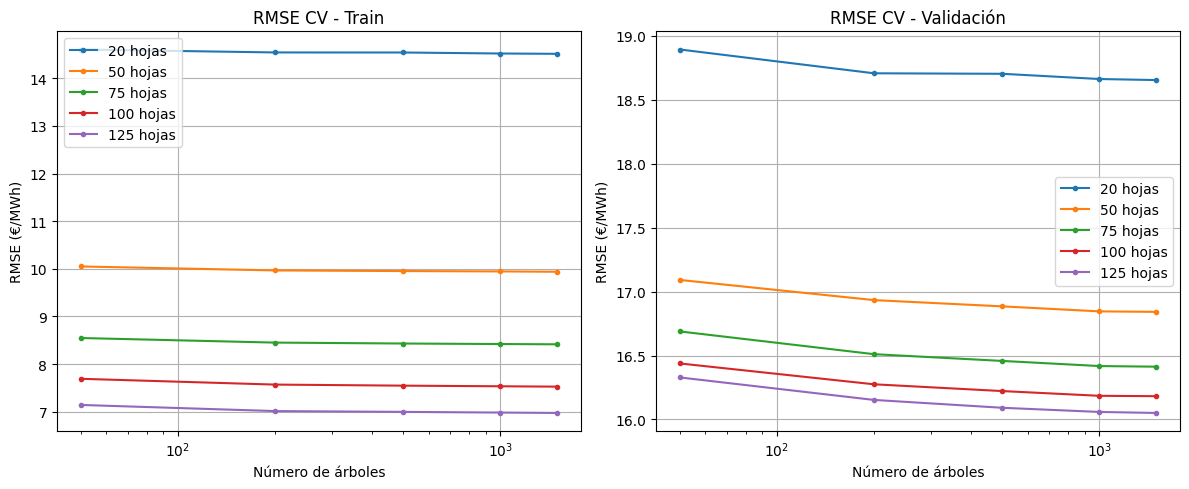

In [15]:
# Aseguramos orden correcto
df_plot = df_total.sort_values(["max_leaf_nodes", "n_estimators"])

v_hojas = sorted(df_plot["max_leaf_nodes"].unique())

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for hh in v_hojas:
    df_hh = df_plot[df_plot["max_leaf_nodes"] == hh]

    ax[0].plot(
        df_hh["n_estimators"],
        df_hh["rmse_train_mean"],
        marker="o",
        markersize=3,
        label=f"{hh} hojas"
    )

    ax[1].plot(
        df_hh["n_estimators"],
        df_hh["rmse_val_mean"],
        marker="o",
        markersize=3,
        label=f"{hh} hojas"
    )

# ---- estética ----
ax[0].set_title("RMSE CV - Train")
ax[1].set_title("RMSE CV - Validación")

for a in ax:
    a.set_xscale("log")
    a.set_xlabel("Número de árboles")
    a.set_ylabel("RMSE (€/MWh)")
    a.grid(True)
    a.legend()

fig.tight_layout()
plt.show()


## 1. Selección y entrenamiento del modelo


In [5]:
model = RandomForestRegressor(max_leaf_nodes=50, n_estimators=1500)
X_train_drop= X_train.drop(columns=["time_idx"])
X_test_drop= X_test.drop(columns=["time_idx"])

model.fit(X_train_drop, y_train)

y_train_pred = model.predict(X_train_drop)
y_test_pred = model.predict(X_test_drop)

## 2. Análisis de OUTPUTS

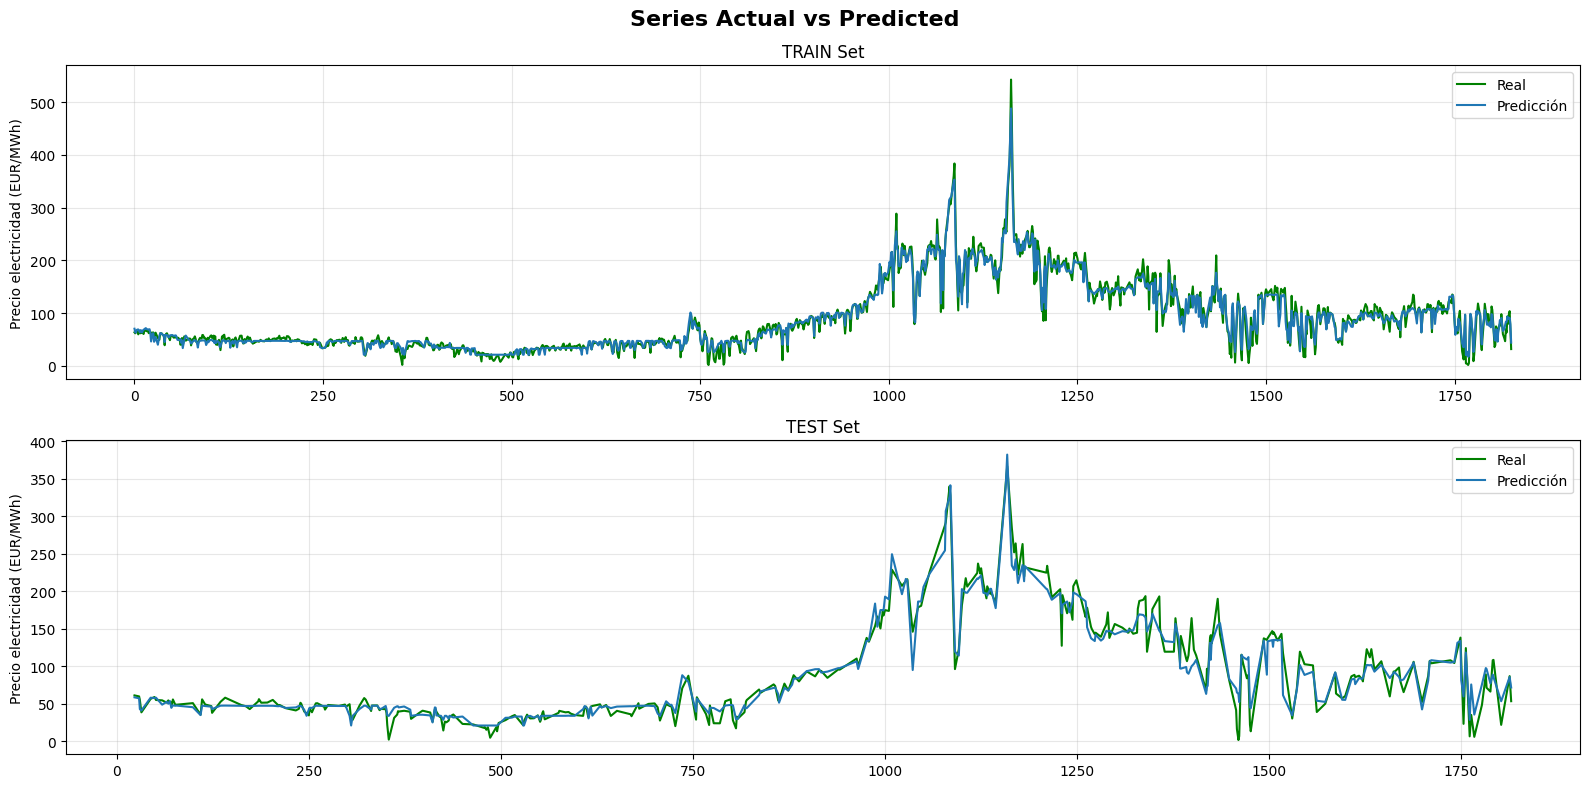


El error (rmse) de train es: 10.39 EUR/MWh
MAPE de train = 17.93 %
WAPE de train = 8.20 %
R2 train = 0.9747


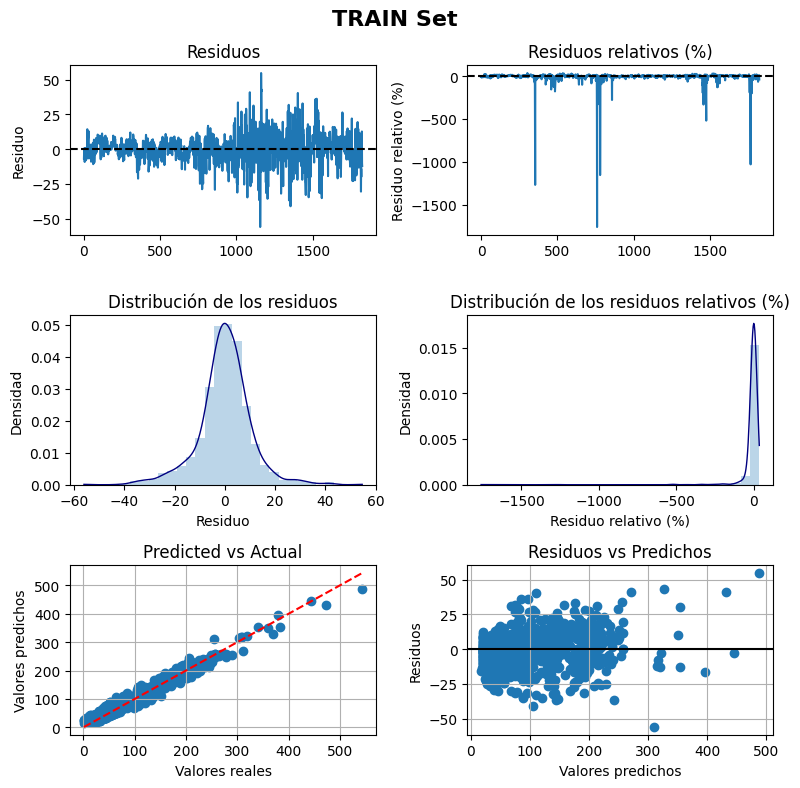


El error (rmse) de test es: 14.61 EUR/MWh
MAPE de test = 34.66 %
WAPE de test = 10.68 %
R2 test = 0.9546


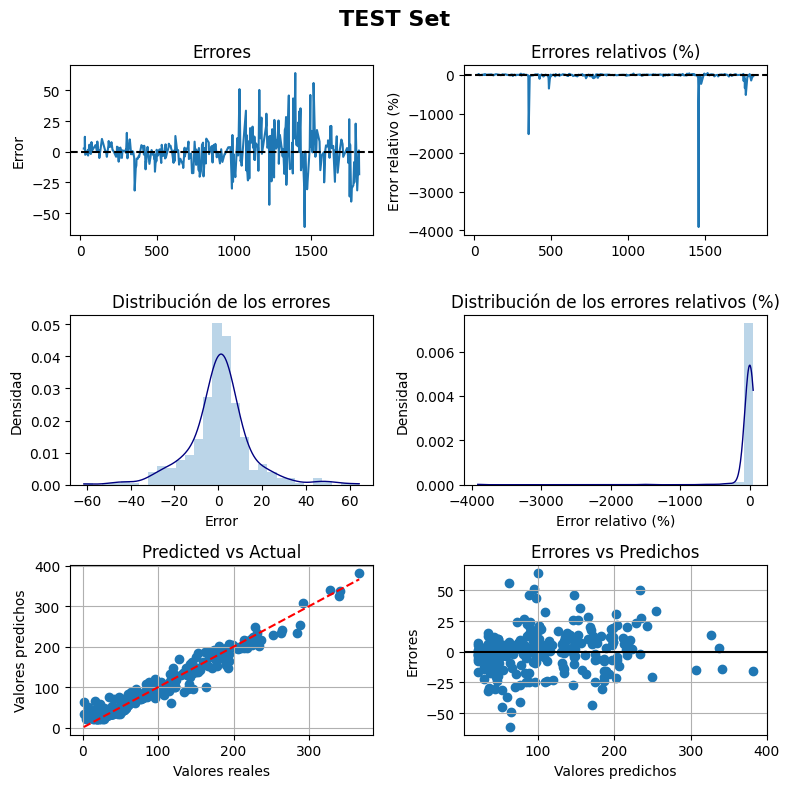

In [6]:
tfm_err.estudio_residuos_errores_index(X_train,X_test,y_train,y_test,y_train_pred,y_test_pred)

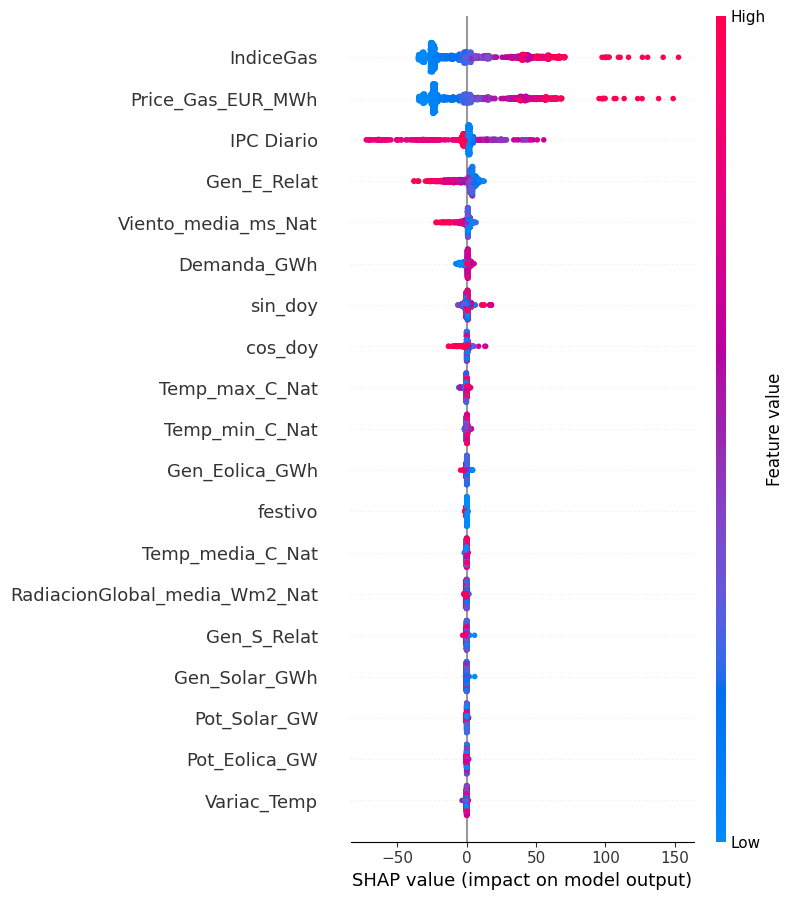

In [10]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_drop)

# Importancia global
shap.summary_plot(shap_values, X_train_drop)

In [17]:
shap_values.shape


(1460, 20)